In [1]:
#pip install matplotlib

In [2]:
from PIL import Image
import numpy as np
import os
import cv2
from os.path import join, exists, basename
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd 
from scipy.ndimage import zoom
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
import tensorflow as tf
import keras
from keras import backend as K
from keras import layers
from tensorflow.keras.utils import to_categorical


from tensorflow.keras import models, layers, regularizers


In [3]:
"""from google.colab import drive
drive.mount('/content/drive/')"""

"from google.colab import drive\ndrive.mount('/content/drive/')"

In [4]:
img_shape = 512

npy_path = "C:/Users/eddie/Desktop/organ/2D_npy_2/"

#new_npy_path = "/content/drive/MyDrive/train/organ/data/aug_3D_npy/"
#degree = 30
#n_aug = 6
#data_list = np.load("./data_list.npy")

# **Load csv and split data**

In [5]:
#load 
import pandas as pd
data = pd.read_csv("C:/Users/eddie/Desktop/organ/Multiorgan_data_2.csv")

In [6]:
def generator(file, label, batch_size, n=5):
    samples_per_epoch = len(file)
    number_of_batches = samples_per_epoch / batch_size
    counter = 0
    path = "C:/Users/eddie/Desktop/organ/label_2/"
    
    while 1:
        tmp=[]
        for data in file[batch_size * counter:batch_size * (counter + 1)]:
            img = cv2.imread(path+data)
            tmp.append(img)
        
        X_batch = np.array(tmp).astype(np.float32)
        X_batch /= 255.
        
        
        mask = []
        for data in label[batch_size * counter:batch_size * (counter + 1)]:
            img = cv2.imread(path+data)
            mask.append(img) 
        y_batch = np.array(mask)
        #print("mask", y_batch.shape)
        y_batch = y_batch[:,:,:,0] if(len(y_batch.shape) == 4) else y_batch[:,:,0] 
        #print("y_batch", y_batch.shape)
        
        y_batch = to_categorical(y_batch, n)
        #print("y", y_batch.shape)
        counter += 1
        yield X_batch, y_batch
        
        tmp=[]
        mask = []
        # restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            counter = 0

In [7]:
len(data)

758

##split training, validation set

In [8]:
x_train, x_val, y_train, y_val = train_test_split(data["file"],data["label"], test_size=0.2, random_state=42)

train_list = x_train
val_list = x_val


#print(data_list)



print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

np.save("./train_list.npy",train_list)
np.save("./val_list.npy",val_list)

(606,) (606,)
(152,) (152,)


#Augmentation

In [9]:
def add_mask(image):
    img=[]
    for i in range(len(image)):
        img.append(image[i]+"_mask")
    return img

In [10]:
def path_aug(image, m=False):
  img = []
  for i in range(len(image)):
    if(m):
      img.append(str(image[i]))        
    else:
      img.append(str(image[i]))
            
  return img

In [11]:
"""X_train = np.append(x_train,path_aug(x_train,))
y_train = add_mask(y_train)
Y_train = np.append(y_train,path_aug(y_train,True))

X_val = np.append(x_val,path_aug(x_val))
y_val = add_mask(y_val)
Y_val = np.append(y_val,path_aug(y_val,True))"""

'X_train = np.append(x_train,path_aug(x_train,))\ny_train = add_mask(y_train)\nY_train = np.append(y_train,path_aug(y_train,True))\n\nX_val = np.append(x_val,path_aug(x_val))\ny_val = add_mask(y_val)\nY_val = np.append(y_val,path_aug(y_val,True))'

In [12]:
"""print("X shape: ",X_train.shape,X_val.shape)
print("y shape: ",Y_train.shape,Y_val.shape)
#print(np.load(X_train[0]).shape)
#a=np.load(X_train[0])
print(Y_val[3])
#np.load()"""

'print("X shape: ",X_train.shape,X_val.shape)\nprint("y shape: ",Y_train.shape,Y_val.shape)\n#print(np.load(X_train[0]).shape)\n#a=np.load(X_train[0])\nprint(Y_val[3])\n#np.load()'

# **Build Model**

###  Attention Unet

In [13]:




#dropout_rate = 0.5
#tf.keras.backend.clear_session()



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




def UNet(input_shape, NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
# ()
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

def Attention_ResUNet(input_shape, NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model
    #-*-----------------------------------------------------------------------------------------------------  

### loss function

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean(2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


### Train


In [15]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 
channels = 3
LR = 0.0001
optim = Adam(LR)
n_classes= 5  # None and objects
batch_size = 3
ep = 100


In [16]:
model = Attention_ResUNet((img_shape,img_shape,channels), NUM_CLASSES=n_classes)
model.compile(optimizer = optim, loss=dice_coef_loss, metrics = ['accuracy',dice_coef])
print(model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
___________________________________________________________________________________

In [17]:
save_path = "C:/Users/eddie/Desktop/organ/"

In [18]:
tb = tf.keras.callbacks.TensorBoard(log_dir= "./log/Attention_UNet"+"_ep"+str(ep)+"_dice")
md = tf.keras.callbacks.ModelCheckpoint(save_path+"Attention_UNet"+"_ep"+str(ep)+"_dice.h5",save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                           patience=5, mode='min', verbose=1,
                           min_lr=1e-6)

In [19]:
history=model.fit(generator(x_train, y_train, batch_size), epochs=ep, 
                  steps_per_epoch=len(x_train)/batch_size,
                  validation_data= generator(x_val, y_val, batch_size),
                  validation_steps=len(x_val)/batch_size,
                  verbose=1,callbacks=[tb,md,reduce_lr])



Epoch 1/100


C:\Users\eddie\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


202/202 [==============================] - 79s 308ms/step - loss: 0.6716 - accuracy: 0.6562 - dice_coef: 0.3284 - val_loss: 0.7422 - val_accuracy: 0.2517 - val_dice_coef: 0.2577
Epoch 2/100
202/202 [==============================] - 60s 296ms/step - loss: 0.6625 - accuracy: 0.8417 - dice_coef: 0.3375 - val_loss: 0.6801 - val_accuracy: 0.8337 - val_dice_coef: 0.3198
Epoch 3/100
202/202 [==============================] - 60s 295ms/step - loss: 0.6563 - accuracy: 0.8668 - dice_coef: 0.3437 - val_loss: 0.6502 - val_accuracy: 0.9348 - val_dice_coef: 0.3497
Epoch 4/100
202/202 [==============================] - 60s 295ms/step - loss: 0.6507 - accuracy: 0.8761 - dice_coef: 0.3493 - val_loss: 0.6496 - val_accuracy: 0.9080 - val_dice_coef: 0.3503
Epoch 5/100
202/202 [==============================] - 61s 301ms/step - loss: 0.6450 - accuracy: 0.8831 - dice_coef: 0.3550 - val_loss: 0.6500 - val_accuracy: 0.8800 - val_dice_coef: 0.3499
Epoch 6/100
202/202 [==============================] - 61s 303

202/202 [==============================] - 60s 295ms/step - loss: 0.4293 - accuracy: 0.9342 - dice_coef: 0.5707 - val_loss: 0.4430 - val_accuracy: 0.8943 - val_dice_coef: 0.5569
Epoch 45/100
202/202 [==============================] - 60s 295ms/step - loss: 0.4240 - accuracy: 0.9376 - dice_coef: 0.5760 - val_loss: 0.4330 - val_accuracy: 0.9012 - val_dice_coef: 0.5668
Epoch 46/100
202/202 [==============================] - 60s 295ms/step - loss: 0.4190 - accuracy: 0.9371 - dice_coef: 0.5810 - val_loss: 0.4159 - val_accuracy: 0.9405 - val_dice_coef: 0.5840
Epoch 47/100
202/202 [==============================] - 60s 295ms/step - loss: 0.4136 - accuracy: 0.9382 - dice_coef: 0.5864 - val_loss: 0.4219 - val_accuracy: 0.9055 - val_dice_coef: 0.5779
Epoch 48/100
202/202 [==============================] - 60s 295ms/step - loss: 0.4086 - accuracy: 0.9383 - dice_coef: 0.5914 - val_loss: 0.4142 - val_accuracy: 0.9094 - val_dice_coef: 0.5857
Epoch 49/100
202/202 [==============================] - 60

Epoch 87/100
202/202 [==============================] - 58s 289ms/step - loss: 0.2380 - accuracy: 0.9654 - dice_coef: 0.7620 - val_loss: 0.2318 - val_accuracy: 0.9672 - val_dice_coef: 0.7680
Epoch 88/100
202/202 [==============================] - 65s 323ms/step - loss: 0.2352 - accuracy: 0.9637 - dice_coef: 0.7648 - val_loss: 0.2344 - val_accuracy: 0.9589 - val_dice_coef: 0.7654
Epoch 89/100
202/202 [==============================] - 59s 294ms/step - loss: 0.2311 - accuracy: 0.9658 - dice_coef: 0.7689 - val_loss: 0.2233 - val_accuracy: 0.9657 - val_dice_coef: 0.7766
Epoch 90/100
202/202 [==============================] - 57s 283ms/step - loss: 0.2277 - accuracy: 0.9661 - dice_coef: 0.7723 - val_loss: 0.2176 - val_accuracy: 0.9728 - val_dice_coef: 0.7822
Epoch 91/100
202/202 [==============================] - 65s 315ms/step - loss: 0.2241 - accuracy: 0.9671 - dice_coef: 0.7759 - val_loss: 0.2266 - val_accuracy: 0.9604 - val_dice_coef: 0.7731
Epoch 92/100
202/202 [=======================

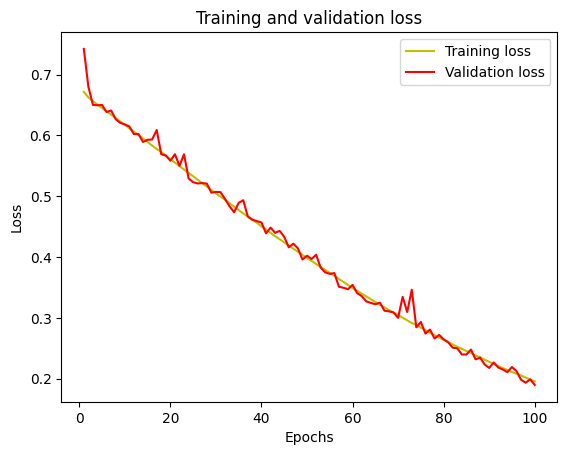

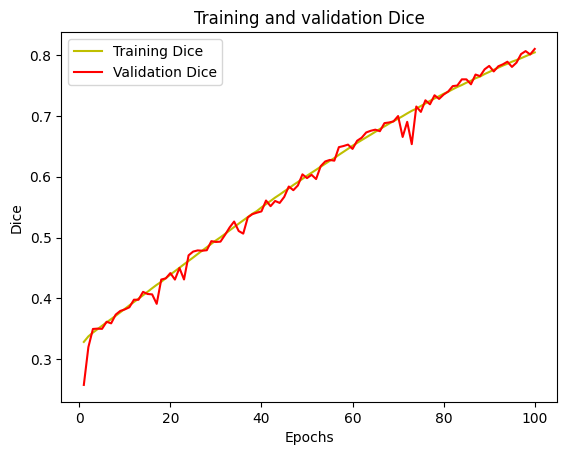

In [20]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

# Load & Predict

In [21]:
model.save(save_path+'Attention_model.h5')

C:\Users\eddie\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
from keras.metrics import MeanIoU
from keras.models import load_model
model_path = save_path
my_model = load_model(model_path + 'Attention_model.h5', compile=False)
path = "C:/Users/eddie/Desktop/organ/label_2/"

In [23]:
def load_img(f,label,p=path,n=5):
    img = []
    mask =[]
    
    img.append(cv2.imread(p + f))
    mask.append(cv2.imread(p + label))
        
    img = np.array(img)
    mask = np.array(mask)
    img = img/255.
    mask = mask[:,:,:,0]if(len(mask.shape) == 4) else mask[:,:,0] 
    mask = to_categorical(mask, n)
    return img,mask

#IoU
def get_IoU(i, gth, n=5, per_acc = False):
  y_pred = my_model.predict(i)
  y_pred_argmax = np.argmax(y_pred, axis=3)
  y_gth_argmax = np.argmax(gth, axis=3)
  print("ture:",np.unique(y_gth_argmax))
  print("pred:",np.unique(y_pred_argmax))
  #Using built in keras function for IoU
  #Only works on TF > 2.0
  IOU_keras = MeanIoU(num_classes=n)  
  IOU_keras.update_state(y_gth_argmax, y_pred_argmax)
  print("IoU =", IOU_keras.result().numpy())
  if(per_acc):
    class_labels = ['0','1','2','3','4']
    print("per_class_accacy:",per_class_acc(y_gth_argmax, y_pred_argmax, class_labels))
  print()
  return y_pred_argmax,IOU_keras.result().numpy()

def get_mIoU(X_dataset,y_dataset,Save = False):
    tmp = 0
    for i in range(len(X_dataset)):
      print(X_dataset[i])
      img, mask = load_img(X_dataset[i],y_dataset[i])
      pred, IoU = get_IoU(img,mask)
      tmp += IoU
      
      if(Save):
        for j in range(len(pred)):
          pred = np.stack((pred[j],)*3, axis=-1)
          save_predict_img(img,X_dataset[i],pred)
    miou = tmp/len(X_dataset)
    print("Mean IoU =", miou)

def get_mIoU(X_dataset, y_dataset, state = "", Save = False, per_acc = False):
    tmp = 0

    for i in range(len(X_dataset)):
      print(X_dataset[i])
      img, mask = load_img(X_dataset[i],y_dataset[i])
      if(per_acc):
        pred, IoU = get_IoU(img, mask , per_acc = per_acc)
      else:
        pred, IoU = get_IoU(img,mask)

      tmp += IoU
      if(Save):
        for j in range(len(pred)):
          pred = np.stack((pred[j],)*3, axis=-1)
          save_predict_img(img,X_dataset[i],pred,state)
    #miou = tmp/len(dataset_list)
    miou = tmp/len(X_dataset)
    print("Mean IoU =", miou)
    
    
def per_class_acc(y_gth_argmax, y_pred_argmax, class_labels):
  class_accuracies = {class_label:[] for class_label in class_labels}
  for class_ in np.unique((class_labels)):
      class_acc = np.mean(K.flatten(y_pred_argmax)[K.flatten(y_gth_argmax ) == int(class_)] == int(class_))
      class_accuracies[str(class_)] =  class_acc 
  return class_accuracies


def save_predict_img(test,test_name,pred,state,path='2D_model'):
    l = test_name.split("/")
    file_path = "./predict/"+path+"/"+state+"/"+l[0]+"/"
    mask_path = "./predict/"+path+"/"+state+"/"+l[0]+"/mask/"
    label_path = "./predict/"+path+"/"+state+"/"+l[0]+"/label/"
    if not os.path.isdir(file_path):
      os.makedirs(file_path)
    if not os.path.isdir(mask_path):
      os.makedirs(mask_path)
    if not os.path.isdir(label_path):
      os.makedirs(label_path)
    for i in range(len(pred)):
      for j in range(len(pred[i])):
        if ((pred[i][j] == [0,0,0]).all()):
          pred[i][j] = 0
        else:
          pred[i][j] = colors[objects[pred[i][j][0]]]
    img = test[0]*255
    mask = (pred.astype(np.uint8))

    Image.fromarray(np.uint8((img))).save(file_path + l[1])
    Image.fromarray(np.uint8((0.8*img+0.2*mask))).save(label_path + l[1])
    Image.fromarray(np.uint8(mask)).save(mask_path + l[1])


In [26]:
objects = {1: 'liver', 2: 'lymph_node', 3: 'omentum', 4: 'Ovarian'}
colors = {'liver': (28, 230, 255), 'lymph_node': (206, 13, 122),
          'omentum': (245, 135, 12), 'Ovarian': (23, 206, 0)}

In [27]:
train_pred_argmax = get_mIoU(x_train.tolist(),y_train.tolist(),"train",True,True)

55_multi_organ/616.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.512417
per_class_accacy: {'0': 0.9677581361978596, '1': 0.924261210994007, '2': 1.0, '3': nan, '4': nan}

52_multi_organ/325.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4569172
per_class_accacy: {'0': 0.990202027914977, '1': 0.9273591866852505, '2': 0.8973214285714286, '3': nan, '4': nan}

61_multi_organ/567.png
ture: [0 4]
pred: [0 1 2 3 4]
IoU = 0.1959211
per_class_accacy: {'0': 0.9817369668710695, '1': nan, '2': nan, '3': nan, '4': 0.0001443209698369173}

52_multi_organ/381.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.26870474
per_class_accacy: {'0': 0.9933714648134613, '1': nan, '2': 0.9982456140350877, '3': nan, '4': 0.0}

50_multi_organ/149.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.23972316
per_class_accacy: {'0': 0.9804690579424518, '1': nan, '2': 1.0, '3': nan, '4': 0.0012891581797086502}

52_multi_organ/326.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.53767717
per_class_accacy: {'0': 0.9846456111206507, '1': 0.93167996

52_multi_organ/30.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.40042382
per_class_accacy: {'0': 0.984748149935024, '1': 0.8561066916237716, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/260.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.25829723
per_class_accacy: {'0': 0.9876763165568787, '1': nan, '2': 1.0, '3': nan, '4': 0.003763885063802442}

61_multi_organ/551.png
ture: [0]
pred: [0 2]
IoU = 0.494236
per_class_accacy: {'0': 0.9884719848632812, '1': nan, '2': nan, '3': nan, '4': nan}

53_multi_organ/467.png
ture: [0 2 4]
pred: [0 2 3 4]
IoU = 0.2844685
per_class_accacy: {'0': 0.9885695382280254, '1': nan, '2': 1.0, '3': nan, '4': 0.00021408691928923143}

60_multi_organ/434.png
ture: [0 2]
pred: [0 1 2 3 4]
IoU = 0.2888087
per_class_accacy: {'0': 0.9872584952999803, '1': nan, '2': 0.9144564811355995, '3': nan, '4': nan}

61_multi_organ/569.png
ture: [0 4]
pred: [0 1 2 3 4]
IoU = 0.19561455
per_class_accacy: {'0': 0.9791055283536754, '1': nan, '2': nan, '3': nan, '4': 0.0}

62_multi_organ

55_multi_organ/649.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.23475845
per_class_accacy: {'0': 0.9623430625171241, '1': nan, '2': 1.0, '3': nan, '4': 7.630675314765356e-05}

63_multi_organ/824.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.5129891
per_class_accacy: {'0': 0.9896398480883385, '1': 0.7703562945368171, '2': 1.0, '3': nan, '4': nan}

62_multi_organ/642.png
ture: [0]
pred: [0 2]
IoU = 0.49056435
per_class_accacy: {'0': 0.9811286926269531, '1': nan, '2': nan, '3': nan, '4': nan}

53_multi_organ/435.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.4695116
per_class_accacy: {'0': 0.9971355592743928, '1': 0.42033898305084744, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/147.png
ture: [0 2]
pred: [0 2]
IoU = 0.66488916
per_class_accacy: {'0': 0.9835772883286389, '1': nan, '2': 1.0, '3': nan, '4': nan}

62_multi_organ/638.png
ture: [0]
pred: [0 2 3]
IoU = 0.32792792
per_class_accacy: {'0': 0.9837837219238281, '1': nan, '2': nan, '3': nan, '4': nan}

52_multi_organ/33.png
ture: [0 1 2]
pred:

60_multi_organ/423.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.39538115
per_class_accacy: {'0': 0.9822905612085648, '1': 0.8621050428960033, '2': 0.9971724787935909, '3': nan, '4': nan}

59_multi_organ/366.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.2664039
per_class_accacy: {'0': 0.9876734118594583, '1': nan, '2': 0.9262202043132803, '3': nan, '4': 0.0002318750966146236}

63_multi_organ/853.png
ture: [0 2]
pred: [0 1 2]
IoU = 0.44973823
per_class_accacy: {'0': 0.9941421793694522, '1': nan, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/24.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4570368
per_class_accacy: {'0': 0.9875461856118235, '1': 0.9697328427451608, '2': 0.9964243146603099, '3': nan, '4': nan}

62_multi_organ/60.png
ture: [0 1]
pred: [0 1 2 3 4]
IoU = 0.32889044
per_class_accacy: {'0': 0.9797407257456318, '1': 0.7570029382957885, '2': nan, '3': nan, '4': nan}

53_multi_organ/49.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.567564
per_class_accacy: {'0': 0.9886473787805032, '1': 0.9

56_multi_organ/72.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.49194473
per_class_accacy: {'0': 0.9923742164716924, '1': 0.8758269265152869, '2': 0.9259927797833934, '3': nan, '4': nan}

60_multi_organ/441.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.3821488
per_class_accacy: {'0': 0.9920899122300052, '1': nan, '2': 0.8589546502690238, '3': nan, '4': nan}

57_multi_organ/113.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.45572168
per_class_accacy: {'0': 0.9834376165949764, '1': 0.9590767897132124, '2': 0.9695074276778733, '3': nan, '4': nan}

57_multi_organ/116.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4156975
per_class_accacy: {'0': 0.9760441495237067, '1': 0.9380733944954128, '2': 1.0, '3': nan, '4': nan}

60_multi_organ/450.png
ture: [0 2]
pred: [0 2]
IoU = 0.6866331
per_class_accacy: {'0': 0.9884463023941167, '1': nan, '2': 1.0, '3': nan, '4': nan}

50_multi_organ/150.png
ture: [0 2 4]
pred: [0 1 2 3]
IoU = 0.26492947
per_class_accacy: {'0': 0.9950041213096864, '1': nan, '2': 0.9135638297

50_multi_organ/12.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.38237765
per_class_accacy: {'0': 0.9819226660969879, '1': 0.7360161705255421, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/111.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.46032462
per_class_accacy: {'0': 0.9836898604215943, '1': 0.9787241160137825, '2': 0.9837225760792639, '3': nan, '4': nan}

57_multi_organ/156.png
ture: [0 2]
pred: [0 2]
IoU = 0.6675477
per_class_accacy: {'0': 0.993339355984627, '1': nan, '2': 0.9966960352422908, '3': nan, '4': nan}

50_multi_organ/131.png
ture: [0 2]
pred: [0 2]
IoU = 0.57642806
per_class_accacy: {'0': 0.9873684935121554, '1': nan, '2': 1.0, '3': nan, '4': nan}

60_multi_organ/48.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.48824987
per_class_accacy: {'0': 0.9840080458103798, '1': 0.9553733145502113, '2': 0.9710144927536232, '3': nan, '4': nan}

53_multi_organ/440.png
ture: [0 2]
pred: [0 2]
IoU = 0.6255678
per_class_accacy: {'0': 0.9923425577081222, '1': nan, '2': 1.0, '3': nan, '4': nan

63_multi_organ/854.png
ture: [0 2]
pred: [0 2]
IoU = 0.678475
per_class_accacy: {'0': 0.9944320073474542, '1': nan, '2': 0.9987937273823885, '3': nan, '4': nan}

50_multi_organ/15.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.43267545
per_class_accacy: {'0': 0.9824885689269384, '1': 0.9536668675909182, '2': 1.0, '3': nan, '4': nan}

59_multi_organ/348.png
ture: [0 2]
pred: [0 1 2 3 4]
IoU = 0.25142676
per_class_accacy: {'0': 0.9874572362246051, '1': nan, '2': 1.0, '3': nan, '4': nan}

61_multi_organ/516.png
ture: [0 1]
pred: [0 1 2 3 4]
IoU = 0.34994674
per_class_accacy: {'0': 0.9822926336869672, '1': 0.9012090256675502, '2': nan, '3': nan, '4': nan}

53_multi_organ/442.png
ture: [0 2]
pred: [0 2]
IoU = 0.59545153
per_class_accacy: {'0': 0.9898767773961863, '1': nan, '2': 1.0, '3': nan, '4': nan}

50_multi_organ/123.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.44831264
per_class_accacy: {'0': 0.9951152448905922, '1': 0.44349939246658565, '2': 0.8944504896626768, '3': nan, '4': nan}

50_mult

ture: [0 1]
pred: [0 1 2 3 4]
IoU = 0.34311825
per_class_accacy: {'0': 0.9938070228206968, '1': 0.7924059616749468, '2': nan, '3': nan, '4': nan}

52_multi_organ/323.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.5303965
per_class_accacy: {'0': 0.9822194214824974, '1': 0.9216258580617264, '2': 1.0, '3': nan, '4': nan}

63_multi_organ/843.png
ture: [0 2]
pred: [0 2]
IoU = 0.61742884
per_class_accacy: {'0': 0.9861004127338154, '1': nan, '2': 1.0, '3': nan, '4': nan}

59_multi_organ/353.png
ture: [0 2 4]
pred: [0 1 2 3]
IoU = 0.2218571
per_class_accacy: {'0': 0.983067725254234, '1': nan, '2': 1.0, '3': nan, '4': 0.0}

53_multi_organ/44.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.42890882
per_class_accacy: {'0': 0.9683219590525893, '1': 0.945523683557907, '2': 0.9978880675818373, '3': nan, '4': nan}

59_multi_organ/318.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.45604
per_class_accacy: {'0': 0.986878434052447, '1': 0.8920566260322453, '2': 1.0, '3': nan, '4': nan}

60_multi_organ/431.png
ture: 

53_multi_organ/42.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.43016768
per_class_accacy: {'0': 0.9929400708733872, '1': 0.7875445443746818, '2': 0.9988452655889145, '3': nan, '4': nan}

60_multi_organ/46.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.48218423
per_class_accacy: {'0': 0.9846444820653899, '1': 0.9683546179146049, '2': 0.9726288987905792, '3': nan, '4': nan}

63_multi_organ/817.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.45969167
per_class_accacy: {'0': 0.9859780507862561, '1': 0.9096250298543109, '2': 1.0, '3': nan, '4': nan}

61_multi_organ/512.png
ture: [0 1]
pred: [0 1 2 3]
IoU = 0.46515852
per_class_accacy: {'0': 0.9788663347048523, '1': 0.9520694118881853, '2': nan, '3': nan, '4': nan}

57_multi_organ/150.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.34409398
per_class_accacy: {'0': 0.9850385970315899, '1': nan, '2': 0.9879618098796181, '3': nan, '4': nan}

59_multi_organ/335.png
ture: [0 2]
pred: [0 1 2]
IoU = 0.46007815
per_class_accacy: {'0': 0.9924446470784308, '1': nan, 

57_multi_organ/16.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.47728163
per_class_accacy: {'0': 0.985910649929488, '1': 0.964286867512674, '2': 1.0, '3': nan, '4': nan}

56_multi_organ/710.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4369758
per_class_accacy: {'0': 0.9702097347284369, '1': 0.9657757249943212, '2': 0.7087529047250194, '3': nan, '4': nan}

56_multi_organ/732.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.26011604
per_class_accacy: {'0': 0.9647974506522387, '1': nan, '2': 0.9720930232558139, '3': nan, '4': nan}

58_multi_organ/213.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.40777677
per_class_accacy: {'0': 0.9823233983790626, '1': 0.898733474058438, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/220.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.41419512
per_class_accacy: {'0': 0.9875940646113043, '1': 0.8589907377834558, '2': 1.0, '3': nan, '4': nan}

55_multi_organ/627.png
ture: [0 2]
pred: [0 2]
IoU = 0.7101623
per_class_accacy: {'0': 0.9915350862039181, '1': nan, '2': 0.9993964996

53_multi_organ/469.png
ture: [0 2 4]
pred: [0 1 2 3]
IoU = 0.2090611
per_class_accacy: {'0': 0.980986992523018, '1': nan, '2': 1.0, '3': nan, '4': 0.0}

53_multi_organ/40.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.37465245
per_class_accacy: {'0': 0.9772088400192579, '1': 0.9568151147098516, '2': 0.9988674971687429, '3': nan, '4': nan}

50_multi_organ/133.png
ture: [0 2]
pred: [0 2]
IoU = 0.57731676
per_class_accacy: {'0': 0.985509575465381, '1': nan, '2': 0.9712140175219024, '3': nan, '4': nan}

62_multi_organ/639.png
ture: [0]
pred: [0 1 2 3 4]
IoU = 0.19610138
per_class_accacy: {'0': 0.9805068969726562, '1': nan, '2': nan, '3': nan, '4': nan}

55_multi_organ/632.png
ture: [0 2]
pred: [0 1 2]
IoU = 0.45146075
per_class_accacy: {'0': 0.9893523137134526, '1': nan, '2': 1.0, '3': nan, '4': nan}

59_multi_organ/359.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.23628423
per_class_accacy: {'0': 0.9865839100548504, '1': nan, '2': 1.0, '3': nan, '4': 0.0007809449433814916}

58_multi_organ/215.

60_multi_organ/414.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.48035964
per_class_accacy: {'0': 0.9875645895656598, '1': 0.9277152641878669, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/26.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.45622754
per_class_accacy: {'0': 0.9892828964670816, '1': 0.9665545814819263, '2': 0.9985632183908046, '3': nan, '4': nan}

59_multi_organ/327.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.34136868
per_class_accacy: {'0': 0.99146707964059, '1': nan, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/167.png
ture: [0 2]
pred: [0 1 2 3 4]
IoU = 0.24906611
per_class_accacy: {'0': 0.9568311140913881, '1': nan, '2': 1.0, '3': nan, '4': nan}

52_multi_organ/345.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.35179844
per_class_accacy: {'0': 0.9935949249740464, '1': nan, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/142.png
ture: [0 2]
pred: [0 2]
IoU = 0.6975315
per_class_accacy: {'0': 0.9896453633168711, '1': nan, '2': 0.8705982180738226, '3': nan, '4': nan}

60_multi_organ/465.p

52_multi_organ/341.png
ture: [0 2]
pred: [0 2]
IoU = 0.7040552
per_class_accacy: {'0': 0.9914875652440897, '1': nan, '2': 1.0, '3': nan, '4': nan}

59_multi_organ/330.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.3762571
per_class_accacy: {'0': 0.994552988573159, '1': nan, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/134.png
ture: [0 2]
pred: [0 2]
IoU = 0.64774686
per_class_accacy: {'0': 0.986711282171322, '1': nan, '2': 1.0, '3': nan, '4': nan}

55_multi_organ/618.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4011306
per_class_accacy: {'0': 0.9775250698635931, '1': 0.9037818368922048, '2': 0.9106753812636166, '3': nan, '4': nan}

59_multi_organ/338.png
ture: [0 2]
pred: [0 1 2]
IoU = 0.43346795
per_class_accacy: {'0': 0.9910512913786832, '1': nan, '2': 1.0, '3': nan, '4': nan}

52_multi_organ/372.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.22342291
per_class_accacy: {'0': 0.975091851305171, '1': nan, '2': 1.0, '3': nan, '4': 0.0}

61_multi_organ/555.png
ture: [0 4]
pred: [0 2 3]
IoU = 0.248

In [28]:
val_pred_argmax = get_mIoU(x_val.tolist(),y_val.tolist(),"val",True,True)

61_multi_organ/535.png
ture: [0]
pred: [0 2]
IoU = 0.494318
per_class_accacy: {'0': 0.9886360168457031, '1': nan, '2': nan, '3': nan, '4': nan}

52_multi_organ/350.png
ture: [0 2]
pred: [0 2]
IoU = 0.6900476
per_class_accacy: {'0': 0.9912810992029091, '1': nan, '2': 1.0, '3': nan, '4': nan}

56_multi_organ/731.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.30637842
per_class_accacy: {'0': 0.9615527723968622, '1': nan, '2': 0.8951000690131125, '3': nan, '4': nan}

62_multi_organ/629.png
ture: [0]
pred: [0 2]
IoU = 0.4932785
per_class_accacy: {'0': 0.9865570068359375, '1': nan, '2': nan, '3': nan, '4': nan}

61_multi_organ/526.png
ture: [0 1]
pred: [0 1 2 3]
IoU = 0.3326375
per_class_accacy: {'0': 0.9897107588507025, '1': 0.4848719937936385, '2': nan, '3': nan, '4': nan}

52_multi_organ/333.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.522707
per_class_accacy: {'0': 0.9869551693300672, '1': 0.8236889692585895, '2': 1.0, '3': nan, '4': nan}

52_multi_organ/311.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU

50_multi_organ/139.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.22793448
per_class_accacy: {'0': 0.9836012320601784, '1': nan, '2': 1.0, '3': nan, '4': 0.0}

61_multi_organ/546.png
ture: [0]
pred: [0 1 2]
IoU = 0.3278707
per_class_accacy: {'0': 0.983612060546875, '1': nan, '2': nan, '3': nan, '4': nan}

52_multi_organ/332.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.42983237
per_class_accacy: {'0': 0.9873541045575885, '1': 0.8518899460015428, '2': 0.8236363636363636, '3': nan, '4': nan}

62_multi_organ/63.png
ture: [0 1]
pred: [0 1 2 3 4]
IoU = 0.35801047
per_class_accacy: {'0': 0.9679554000616161, '1': 0.9520104791013376, '2': nan, '3': nan, '4': nan}

53_multi_organ/451.png
ture: [0 2]
pred: [0 2]
IoU = 0.58082825
per_class_accacy: {'0': 0.9880069602462856, '1': nan, '2': 1.0, '3': nan, '4': nan}

59_multi_organ/35.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.43035907
per_class_accacy: {'0': 0.9827024350125354, '1': 0.9142336804962723, '2': 1.0, '3': nan, '4': nan}

55_multi_organ/614.p

IoU = 0.19507918
per_class_accacy: {'0': 0.986637118251978, '1': nan, '2': nan, '3': nan, '4': 0.0006074104069649726}

63_multi_organ/863.png
ture: [0 2 4]
pred: [0 2 3 4]
IoU = 0.283223
per_class_accacy: {'0': 0.9814411140166732, '1': nan, '2': 1.0, '3': nan, '4': 0.0003802570537683474}

55_multi_organ/637.png
ture: [0 2]
pred: [0 1 2 3]
IoU = 0.2721204
per_class_accacy: {'0': 0.9814870007794947, '1': nan, '2': 0.9954128440366973, '3': nan, '4': nan}

57_multi_organ/128.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.43715605
per_class_accacy: {'0': 0.9824152910512598, '1': 0.5352564102564102, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/253.png
ture: [0 2 4]
pred: [0 1 2 3 4]
IoU = 0.25693172
per_class_accacy: {'0': 0.99413260085945, '1': nan, '2': 0.8944281524926686, '3': nan, '4': 0.0002722570106180234}

57_multi_organ/112.png
ture: [0 1 2]
pred: [0 1 2 3]
IoU = 0.59514314
per_class_accacy: {'0': 0.9855657524111164, '1': 0.9675445873081708, '2': 0.8276849642004773, '3': nan, '4': nan}



55_multi_organ/617.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.38134724
per_class_accacy: {'0': 0.9667991481073891, '1': 0.9358989923515844, '2': 1.0, '3': nan, '4': nan}

58_multi_organ/217.png
ture: [0 1 2]
pred: [0 1 2 3 4]
IoU = 0.4182847
per_class_accacy: {'0': 0.9885504059942692, '1': 0.9290444654683065, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/159.png
ture: [0 2]
pred: [0 1 2 3 4]
IoU = 0.23203774
per_class_accacy: {'0': 0.9335639290133033, '1': nan, '2': 1.0, '3': nan, '4': nan}

52_multi_organ/344.png
ture: [0 2]
pred: [0 1 2]
IoU = 0.46772897
per_class_accacy: {'0': 0.9920086815474936, '1': nan, '2': 1.0, '3': nan, '4': nan}

57_multi_organ/162.png
ture: [0 2]
pred: [0 1 2 3 4]
IoU = 0.22789359
per_class_accacy: {'0': 0.9227700788607304, '1': nan, '2': 1.0, '3': nan, '4': nan}

Mean IoU = 0.4122715583561282
